# Coding challenge for Babbel Strategic Data Analyst

Let's get started importing the necessary libraries for this task:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
%matplotlib inline

The next step is to load the data into pandas data frames:

In [2]:
sales = pd.read_excel('./data/sales_data.xlsx')
price = pd.read_excel('./data/prices.xlsx')

Run some initial inspection of the data for the sake of understanding:

In [3]:
sales.head()

,customer_id,date,flavor,market
0,3488,2010-01-01,Apple,AUT
1,3480,2010-01-01,Apple,CH
2,9519,2010-01-01,Doughnut,CH
3,4530,2010-01-02,Doughnut,DEU
4,5019,2010-01-02,Coffee,DEU


In [4]:
sales.flavor.sort_values().unique(), price.flavor.sort_values().unique()

(array(['Apple', 'Banana', 'Coffee', 'Doughnut'], dtype=object),
 array(['Apple', 'Banana', 'Coffee', 'Doughnut'], dtype=object))

In [5]:
sales.market.sort_values().unique(), price.market.sort_values().unique()

(array(['AUT', 'CH', 'DEU', 'FRA', 'ITA'], dtype=object),
 array(['AUT', 'CH', 'DEU', 'FRA', 'ITA'], dtype=object))

In [6]:
sales.date.describe()

count                   15996
unique                   3114
top       2017-04-18 00:00:00
freq                       14
first     2010-01-01 00:00:00
last      2018-07-31 00:00:00
Name: date, dtype: object

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15996 entries, 0 to 15995
Data columns (total 4 columns):
customer_id    15996 non-null int64
date           15996 non-null datetime64[ns]
flavor         15996 non-null object
market         15996 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 500.0+ KB


In [8]:
price.head()

,market,flavor,price
0,DEU,Apple,640.0
1,AUT,Apple,700.0
2,CH,Apple,580.0
3,FRA,Apple,760.0
4,ITA,Apple,550.0


In [9]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
market    20 non-null object
flavor    20 non-null object
price     20 non-null float64
dtypes: float64(1), object(2)
memory usage: 560.0+ bytes


In [10]:
price.price.describe()

count      20.000000
mean      825.000000
std       350.210463
min       360.000000
25%       587.500000
50%       735.000000
75%       975.000000
max      1480.000000
Name: price, dtype: float64

## 1 – Warm-up exercise

#### The business wants to know the revenue ​over time​ for each market and each flavor. Prepare a set of meaningful and readable plots.

The first step will to be to join the two tables in order to be able to calculate the revenues:

In [11]:
revenue = pd.merge(sales, price, how='inner', on=['market', 'flavor'])
revenue['date'] = pd.to_datetime(revenue['date'].dt.strftime('%m/%Y'))
revenue.tail()

,customer_id,date,flavor,market,price
15991,7279,2018-06-01,Coffee,FRA,1200.0
15992,6673,2018-06-01,Coffee,FRA,1200.0
15993,7328,2018-06-01,Coffee,FRA,1200.0
15994,1966,2018-06-01,Coffee,FRA,1200.0
15995,5349,2018-07-01,Coffee,FRA,1200.0


In [12]:
markets = revenue.market.unique()
markets

array(['AUT', 'CH', 'DEU', 'FRA', 'ITA'], dtype=object)

In [13]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15996 entries, 0 to 15995
Data columns (total 5 columns):
customer_id    15996 non-null int64
date           15996 non-null datetime64[ns]
flavor         15996 non-null object
market         15996 non-null object
price          15996 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 749.8+ KB


Text(0,0.5,'Yearly Revenue in €')

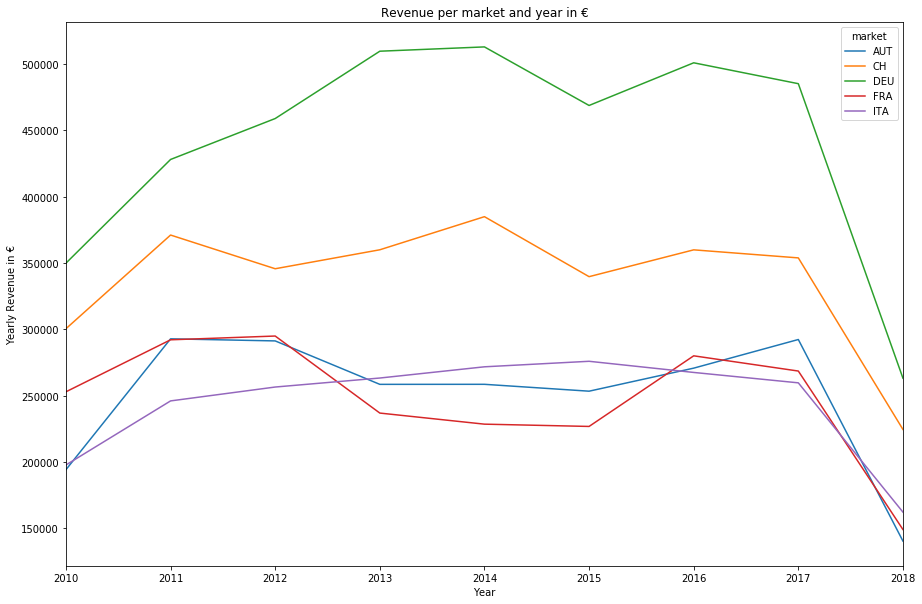

In [14]:
market = revenue.groupby([revenue.date.dt.year, 'market'])['price'].sum()
ax = market.unstack(1).plot(
                            figsize = (15, 10),
                            title = 'Revenue per market and year in €'
                            )

ax.set_xlabel('Year')
ax.set_ylabel('Yearly Revenue in €')

As we see the business is quite stable in all countries. The numbers for 2018 should not be focused on because they only include half of 2018 so far.

Now let's do the same for the different flavors:

Text(0,0.5,'Yearly Revenue in €')

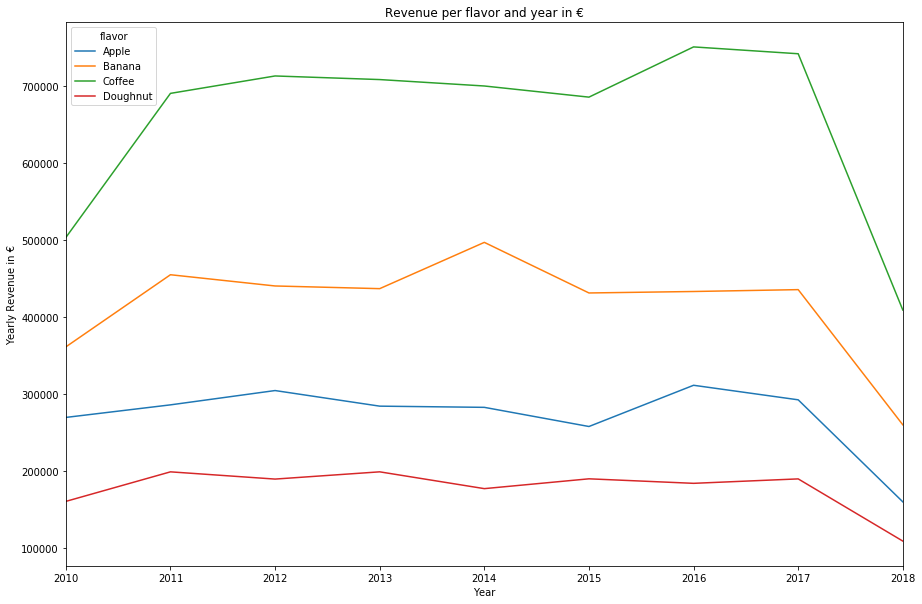

In [15]:
flavor = revenue.groupby([revenue.date.dt.year, 'flavor'])['price'].sum()
ax = flavor.unstack(1).plot(
                            figsize = (15, 10),
                            title = 'Revenue per flavor and year in €'
                            )

ax.set_xlabel('Year')
ax.set_ylabel('Yearly Revenue in €')

Let us inspect the revenue per flavor and year in each market separately:

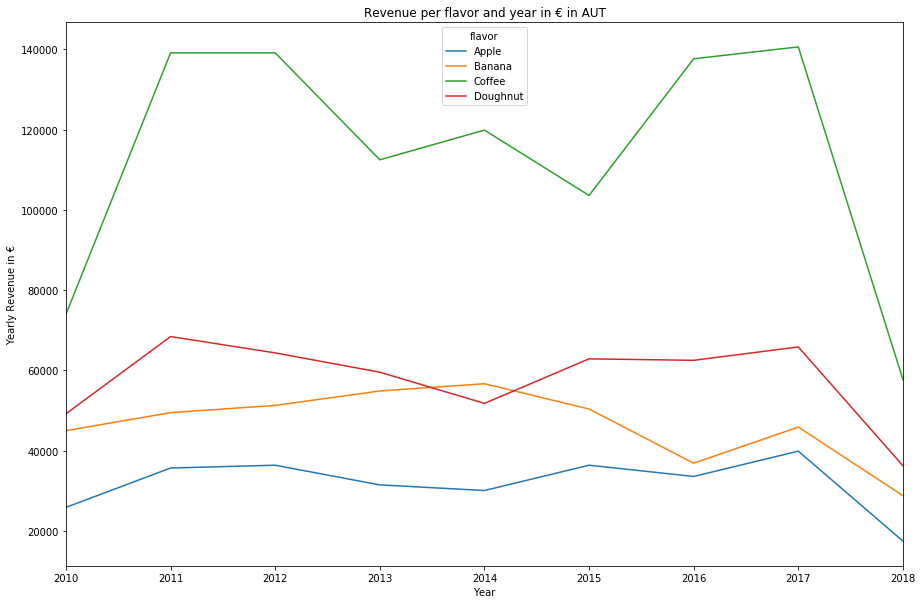

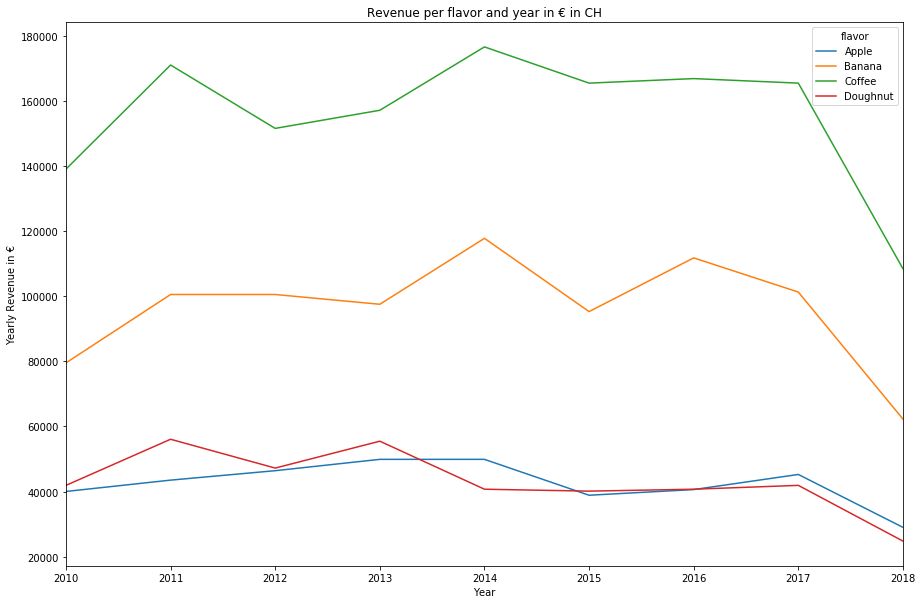

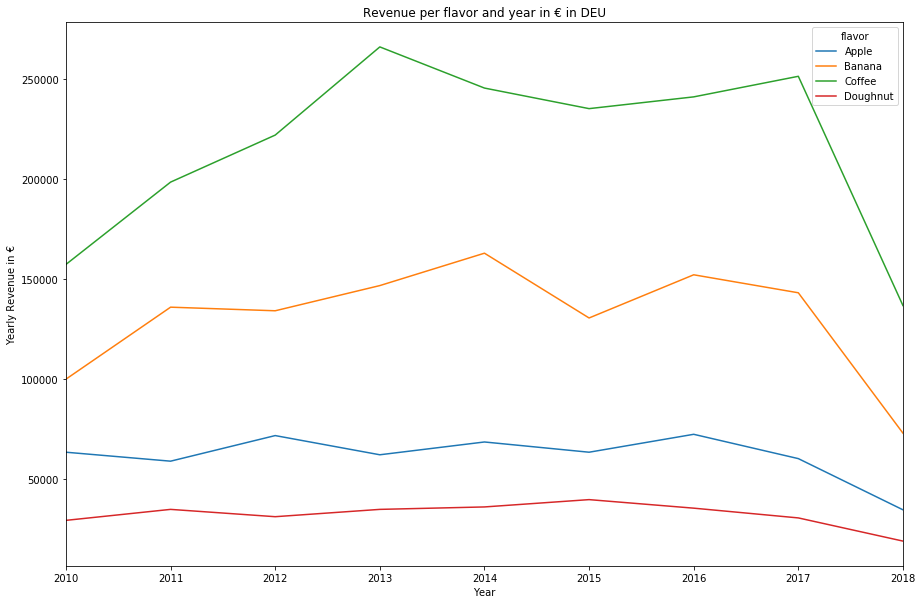

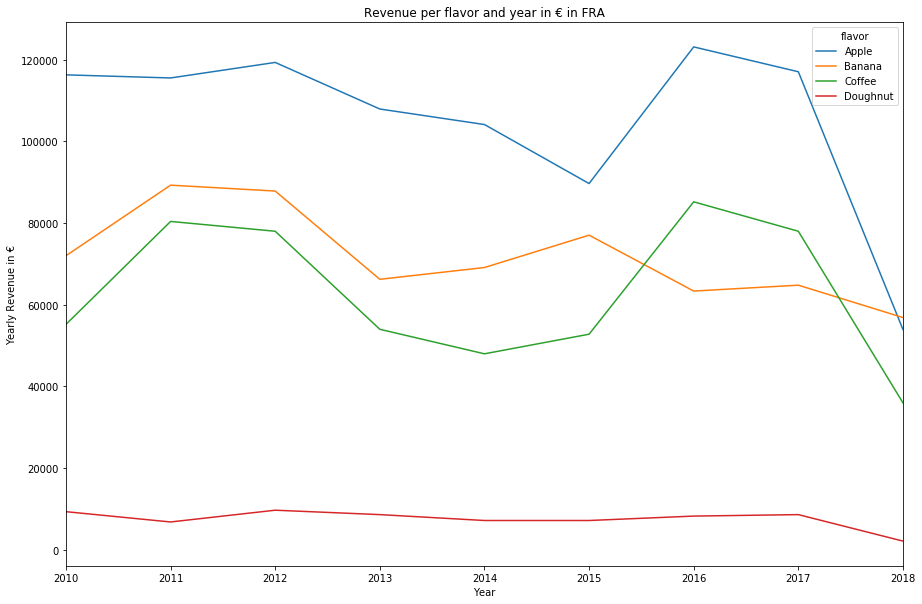

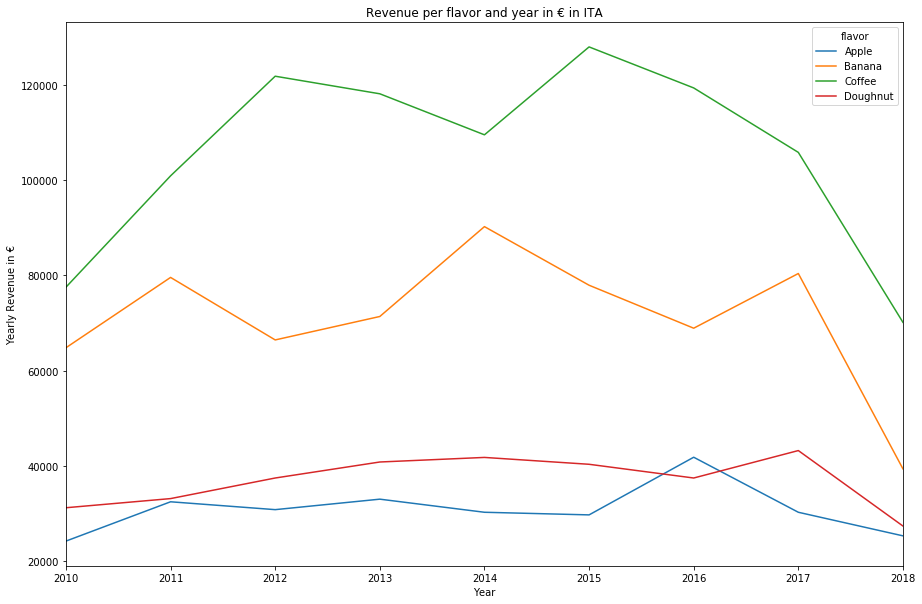

In [16]:
for market in markets:
    both = revenue[revenue.market == market].groupby([revenue.date.dt.year, 'flavor'])['price'].sum()
    ax = both.unstack(1).plot(
                                figsize = (15, 10),
                                title = 'Revenue per flavor and year in € in {}'.format(market)
                                )

    ax.set_xlabel('Year')
    ax.set_ylabel('Yearly Revenue in €')

## 2 – Customer lifetime revenue (CLR)

The business wants to understand how much money we make per customer in each market on average.
Create a plot that breaks down the average revenue per customer for each country ​and​ shows which flavor contributes how much to that revenue.

For example:
In market FRA we make on average 10 € per customer. Of the 10 €, 2 € come from Apple, 3 € come from Banana, etc.

In [17]:
cust_rev = revenue.groupby(['market', 'flavor'])\
.agg({'customer_id':'nunique', 'price': 'sum'})\
.rename(columns={'customer_id':'nr_of_customers', 'price': 'total_revenue'})

cust_rev['revenue_per_cust'] = cust_rev.total_revenue/cust_rev.nr_of_customers

In [18]:
cust_rev.head()

nr_of_customers  total_revenue  revenue_per_cust
market flavor                                                    
AUT    Apple                 391       287000.0        734.015345
       Banana                448       419400.0        936.160714
       Coffee                573      1024160.0       1787.364747
       Doughnut             1144       520960.0        455.384615
CH     Apple                 612       383380.0        626.437908

In [19]:
cust_rev = cust_rev['revenue_per_cust'].unstack(1)
cust_rev.head()

flavor,Apple,Banana,Coffee,Doughnut
market,,,,
AUT,734.015345,936.160714,1787.364747,455.384615
CH,626.437908,956.125828,1532.954048,634.274062
DEU,702.379747,1096.927374,1827.530402,625.775862
FRA,885.837231,874.912043,1367.710843,365.806452
ITA,631.250000,938.002937,1429.759398,520.563380


Text(0.5,1,'Revenue per Market in € divided by Flavors')

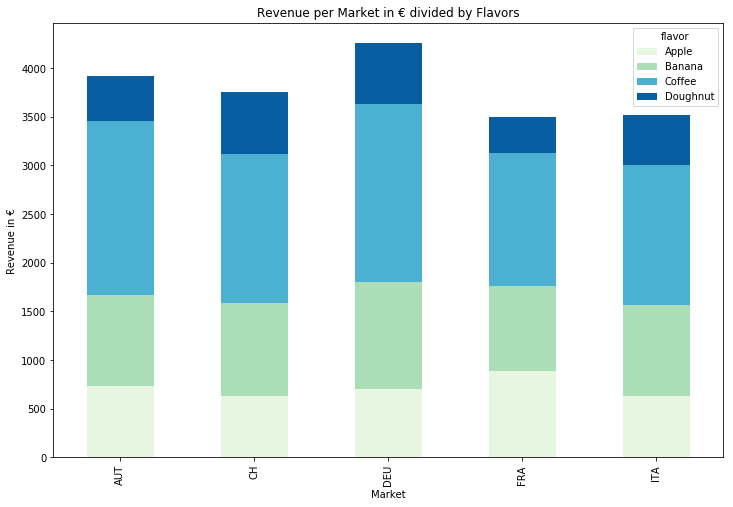

In [20]:
from matplotlib.colors import ListedColormap
cust_rev.plot(kind='bar', stacked=True
              , colormap=ListedColormap(sns.color_palette("GnBu", 10))
              , figsize=(12,8)
              )

plt.xlabel('Market')
plt.ylabel('Revenue in €')
plt.title('Revenue per Market in € divided by Flavors')

# could work by getting heights
#for r1, r2 in zip(ax1, ax2):
#    h1 = r1.get_height()
#    h2 = r2.get_height()
#    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")
#    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=16, fontweight="bold")

#for index, row in cust_rev.iterrows():
#    print(index, row.index[0], row[0])
#    plt.text(index, row.index[i], str(row[i]))
#    for i in range(len(row.index)):
#        plt.text(index, row.index[i], str(row[i]))

## 3 – Flavor preferences in first vs following purchase

The business suspects that customers' first purchases follow different patterns than following purchases.
 
Create plots that show for each country the customers' flavor preferences for their first purchase versus their preferences for following purchases.
* Note that we are not interested in absolute sales or revenue, but in preference of flavor by country!
* We want to see "first" versus "following" purchase, and not "first" versus "second", "third", etc! “Following” means any purchase that is not the first one.

In [21]:
#revenue = pd.merge(sales, price, how='inner', on=['market', 'flavor'])
revenue.head()

,customer_id,date,flavor,market,price
0,3488,2010-01-01,Apple,AUT,700.0
1,3563,2010-01-01,Apple,AUT,700.0
2,2406,2010-01-01,Apple,AUT,700.0
3,7996,2010-01-01,Apple,AUT,700.0
4,6911,2010-01-01,Apple,AUT,700.0


In [22]:
#create a row to distinguish first and follow up purchases
revenue['first'] = 'following'

In [23]:
# create a lookup list
#customers = []

#%%time
#for index, row in revenue.iterrows():
#    if row.customer_id not in customers:
#        customers.append(row.customer_id)
#        revenue.loc[index,'first'] = 'first'

In [24]:
#%%time
#for index in revenue.index:
#    val = revenue.get_value(index, 'customer_id')
#    if val not in customers:
#        customers.append(val)
#        revenue.set_value(index,'first', 'first')

In [25]:
# Fastest option but discarded due to FutureWarning

#%%time
#revenue['id_before'] = revenue.customer_id.shift(fill_value=99999)
#for index in revenue.index:
#    if revenue.get_value(index, 'customer_id') != revenue.get_value(index, 'id_before'):
#        revenue.set_value(index, 'first', 'first')

In [26]:
#%%time
revenue = revenue.sort_values('customer_id')
revenue['id_before'] = revenue.customer_id.shift(fill_value=99999)
for index in revenue.index:
    if revenue.at[index, 'customer_id'] != revenue.at[index, 'id_before']:
        revenue.at[index, 'first'] = 'first'

In [27]:
revenue.groupby('first').sum()

,customer_id,price,id_before
first,,,
first,47760245,8024490.0,47850245
following,31967631,5672680.0,31967631


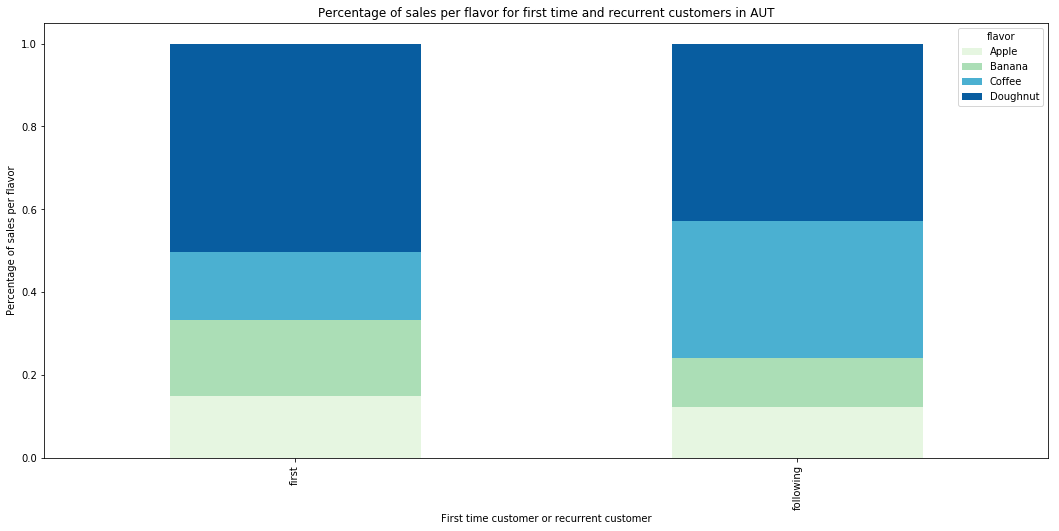

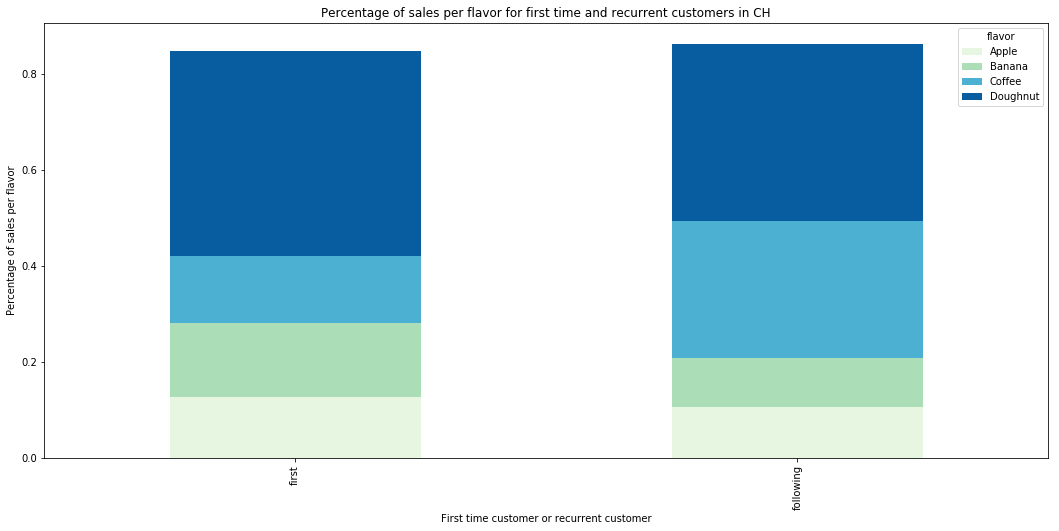

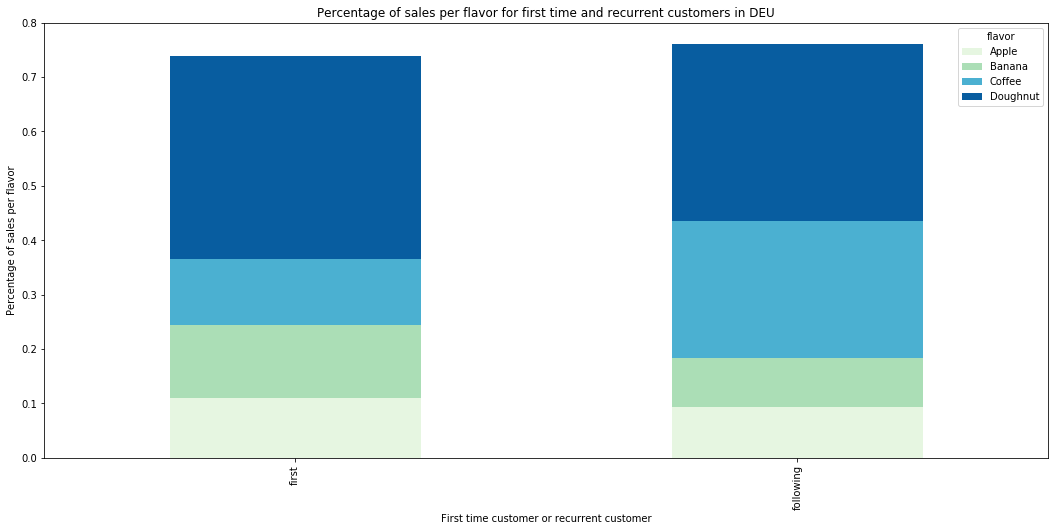

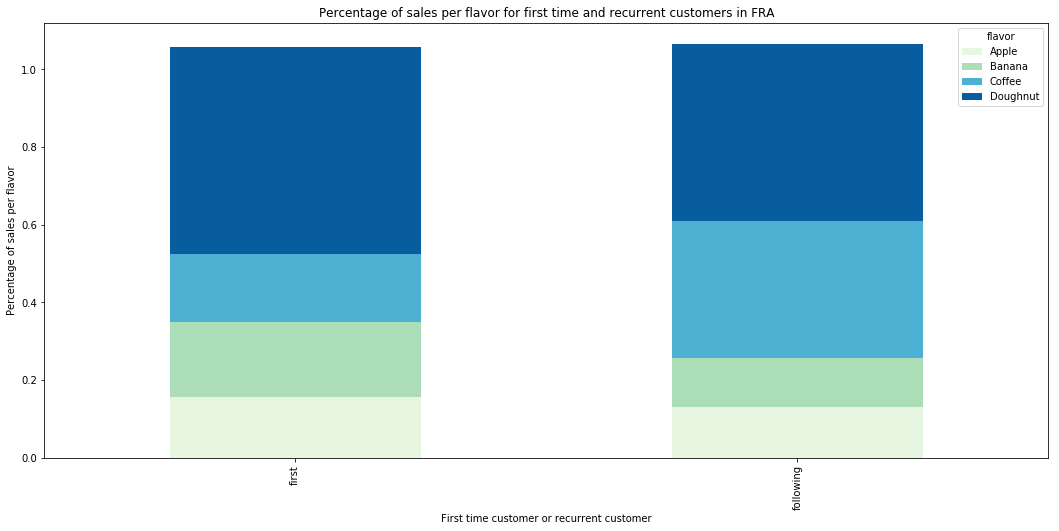

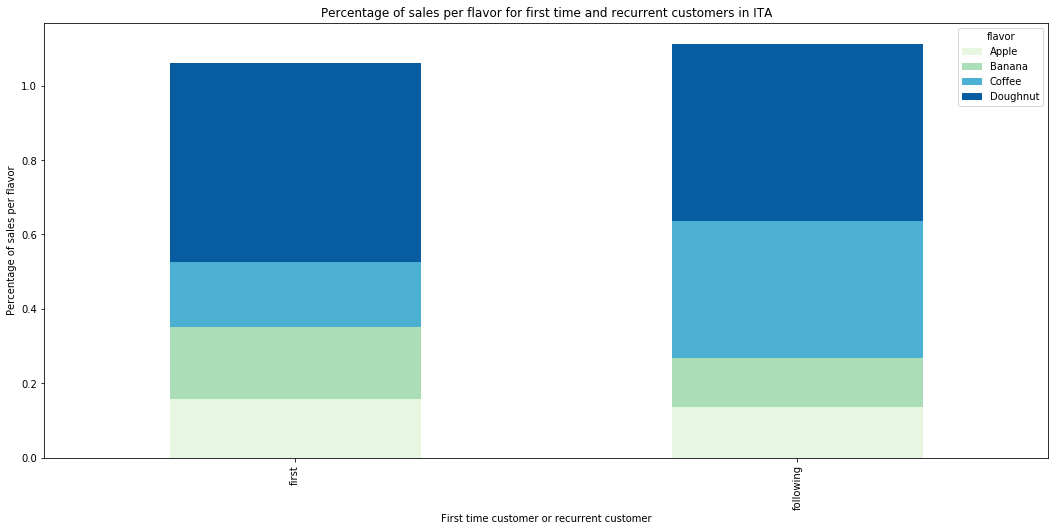

In [28]:
for market in markets:
    each_sum = revenue[revenue['market'] == market].groupby(['first', 'flavor'])['customer_id'].count().sum(level=0)
    first = each_sum = revenue[revenue['market'] == 'AUT'].groupby(['first', 'flavor'])['customer_id'].count()\
            /each_sum
    first.unstack(1).plot(kind='bar', stacked=True, figsize = (18,8),\
                         colormap=ListedColormap(sns.color_palette("GnBu", 10)))
    plt.xlabel('First time customer or recurrent customer')
    plt.ylabel('Percentage of sales per flavor')
    plt.title('Percentage of sales per flavor for first time and recurrent customers in {}'.format(market))

In [29]:
#for market in markets:
#    first[market].unstack(1).plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu", 10))\
#                                 , figsize=(10,5))
#    plt.xlabel('First time customer or recurrent customer')
#    plt.ylabel('Percentage of sales per flavor')
#    plt.title('Percentage of sales per flavor for first time and recurrent customers in {}'.format(market))

## 4 – First versus following in CLR

Create a plot like the one in task 2 showing average revenue by customer. This time, break it down by market (as in task 2) and by the contribution of the first purchase versus the contribution of all following purchases to the average revenue.

Example:
A customer has the following purchases:
* Jan-01-2018 – Apple – 5 €
* Jan-12-2018 – Banana – 3 €
* Feb-07-2018 – Coffee – 4 €

His first purchase contributes 5 €, his following purchases contribute 7 € to what we’ve earned with this customer.
* Here, we are not interested in which products customers actually bought in the first and following purchases! Only the “first vs following” split matters.
* For a customer with only one purchase, the contribution of the following purchases is simply 0 €.
Make sure you choose an appropriate visualisation.

In [30]:
cust_rev_first = revenue.groupby(['market', 'first'])\
.agg({'customer_id':'nunique', 'price': 'sum'})\
.rename(columns={'customer_id':'nr_of_customers', 'price': 'total_revenue'})

cust_rev_first['rev_per_cust'] = cust_rev_first.total_revenue/cust_rev_first.groupby('market')['nr_of_customers'].max()

In [31]:
cust_rev_first = cust_rev_first['rev_per_cust'].unstack(1)
#cust_rev_first = cust_rev_first.stack().unstack(0).head()
cust_rev_first.head()

first,first,following
market,,
AUT,698.357021,581.642979
CH,890.110897,575.443587
DEU,976.693244,692.198909
FRA,776.840841,561.993994
ITA,802.106216,525.570308


Text(0.5,1,'Average customer revenue per market split into first purchase and follow up purchases')

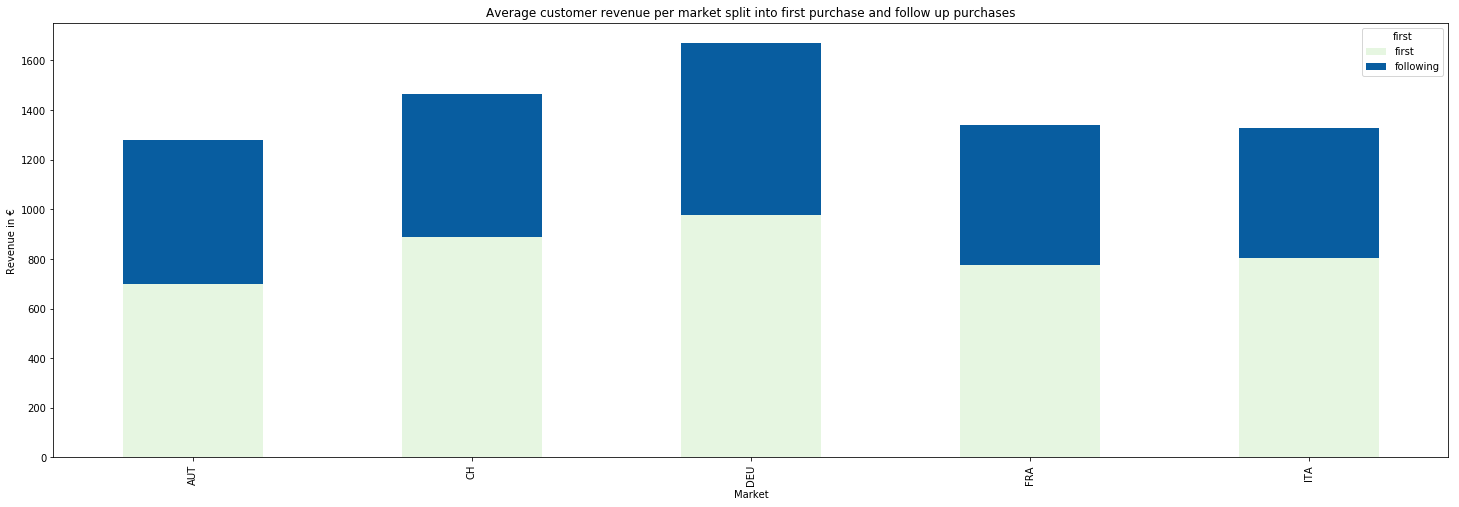

In [32]:
cust_rev_first.plot(kind='bar', stacked=True
                , colormap=ListedColormap(sns.color_palette("GnBu", 10))
                , figsize=(25,8)
                )

plt.xlabel('Market')
plt.ylabel('Revenue in €')
plt.title('Average customer revenue per market split into first purchase and follow up purchases')

## 5 – Transitions

We want to analyse how people switch between flavors. Visualise the probability of flavor transitions, i.e. of a
customer buying flavor B after buying flavor A for all pairs of flavors. If a customer’s last purchase has occurred more than 6 months before the latest date in the dataset, we consider him as “churned”, and we record a transition from his last flavor to a special state called “churned”.
* A customer who bought “Apple, Banana, Apple, Doughnut” contributes 3 transitions: Apple → Banana, Banana → Apple, Apple → Doughnut
* If he bought Doughnut more than 6 months before the latest date in the dataset, there is an additional transition: Doughnut → churned
* A customer with a single purchase X contributes a transition “X → churned” if he bought X more than 6 months before the latest date in the dataset.

We look at this globally, so you don’t need to break down by market. Again, choose an appropriate visualisation.

In [33]:
revenue = revenue.sort_values('customer_id')
revenue = revenue.reset_index(drop=True)
revenue['after'] = revenue.flavor.shift(-1)
revenue['id_after'] = (revenue.customer_id.shift(-1, fill_value='0')).astype(int)
revenue.head()

,customer_id,date,flavor,market,price,first,id_before,after,id_after
0,0,2018-03-01,Coffee,DEU,1470.0,first,99999,Banana,0
1,0,2018-07-01,Banana,DEU,900.0,following,0,Coffee,1
2,1,2018-07-01,Coffee,CH,1390.0,first,0,Coffee,2
3,2,2015-12-01,Coffee,DEU,1470.0,first,1,Coffee,2
4,2,2016-05-01,Coffee,DEU,1470.0,following,2,Apple,3


In [34]:
#%%time
# mark the last purchases of a customer using iterrows()
#for index, row in revenue.iterrows():
#    if revenue.loc[index, 'customer_id'] != revenue.loc[index, 'id_after']:
#        revenue.loc[index, 'first'] = 'last'

In [35]:
#%%time
# mark the last purchase of a customer using revenue.index
#for index in revenue.index:
#    if revenue.loc[index, 'customer_id'] != revenue.loc[index, 'id_after']:
#        revenue.loc[index, 'first'] = 'last'

In [36]:
#%%time
# mark the last purchase of a customer using revenue.index and get. - set.value()
for index in revenue.index:
        val = revenue.at[index,'customer_id']
        try:
            val1 = revenue.at[index+1, 'customer_id']
        except:
            val1 = 99999
        if val1 != val:
            revenue.at[index, 'first'] = 'last'

In [37]:
# find the cutoff date for the churn definition
max_val = revenue.date.max()
churn_date = max_val - pd.Timedelta('0.5 Y')

In [38]:
# create a column for churned customers
revenue['transition'] = ''

In [39]:
# create a column to determine whether a customer has churned or not
for i in revenue.index:
    
    if revenue.at[i, 'date'] < churn_date\
    and revenue.at[i, 'first'] == 'last':
        revenue.at[i, 'transition'] = revenue.at[i, 'flavor'] + ' to ' + 'churned'
        revenue.at[i, 'after'] = 'churned'
    
    elif revenue.at[i, 'first'] == 'last':
        revenue.at[i, 'transition'] = 'none'
        revenue.at[i, 'after'] = 'none'
    
    else:
        revenue.at[i, 'transition'] = revenue.at[i, 'flavor'] + ' to ' + revenue.at[i, 'after']

In [43]:
revenue.head()

,customer_id,date,flavor,market,price,first,id_before,after,id_after,transition
0,0,2018-03-01,Coffee,DEU,1470.0,first,99999,Banana,0,Coffee to Banana
1,0,2018-07-01,Banana,DEU,900.0,last,0,none,1,none
2,1,2018-07-01,Coffee,CH,1390.0,last,0,none,2,none
3,2,2015-12-01,Coffee,DEU,1470.0,first,1,Coffee,2,Coffee to Coffee
4,2,2016-05-01,Coffee,DEU,1470.0,last,2,churned,3,Coffee to churned


Visualize your findings:

In [63]:
#revenue[revenue.transition != 'none'].groupby('transition')['customer_id'].count()\
#.plot(kind='bar', figsize=(15, 8))

#plt.xlabel('Type of transition')
#plt.ylabel('Nr. of observed transitions')
#plt.title('Nr. of observations per transition type')
#/revenue[revenue.transition != 'none'].count()[0]

Text(0.5,1,'Nr. of observations per transition type')

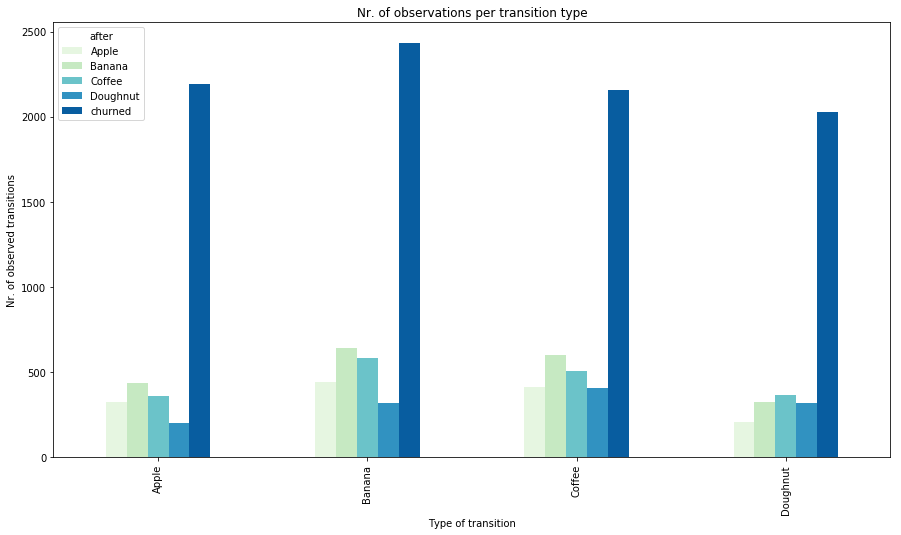

In [62]:
revenue[revenue.after != 'none'].groupby(['flavor', 'after'])['customer_id'].count().unstack(1)\
.plot(kind='bar'\
     , colormap=ListedColormap(sns.color_palette("GnBu", 10))
     , figsize = (15, 8))

plt.xlabel('Type of transition')
plt.ylabel('Nr. of observed transitions')
plt.title('Nr. of observations per transition type')

Check out the historic probability of each transition:

In [41]:
# create a dataframe that contains the historic transition probabilities
trans = revenue[revenue.after != 'none'].groupby(['flavor', 'after'])['customer_id'].count().unstack(1)

for i in trans.index:
    total = trans.sum(axis=1)[i]
    for c in trans.columns:
        trans.loc[i, c] = trans.loc[i, c]/total

In [42]:
# inspect the matrix
trans

after,Apple,Banana,Coffee,Doughnut,churned
flavor,,,,,
Apple,0.092487,0.124075,0.103017,0.056915,0.623506
Banana,0.100091,0.144928,0.131793,0.072464,0.550725
Coffee,0.101566,0.146353,0.124572,0.099853,0.527655
Doughnut,0.063365,0.100584,0.113196,0.098431,0.624423


Save revenue and trans as .csv files to use them for the churn analysis using markov chains:

In [68]:
revenue[['customer_id', 'flavor', 'after']].to_csv('./data/customer_matrix.csv')
trans.to_csv('./data/transition_probabilities.csv')